# OCR research
Optical Character Recognition

Python-tesseract is a python wrapper for Google's Tesseract-OCR <br>
For the intallation : [Link](https://github.com/UB-Mannheim/tesseract/wiki) + `pip install pytesseract`
- Additionnal scrip :
    - add `latin script`
- Additionnal language data :
    - add `english middle (1100-1500)`
    - add `french middle (1400-1600)`
    - add `occitan (post 1500)` <br><br>

In [2]:
import cv2
import json

import pytesseract as OCR
from pytesseract import Output

from difflib import SequenceMatcher
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import traceback
import os


In [3]:
# To let connect to the app Tessdata
#OCR.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
#os.environ["TESSDATA_PREFIX"] = r"C:/Program Files/Tesseract-OCR/tessdata" # Leaving it empty because file is already copy pasted in the current directory
#print(os.getenv("TESSDATA_PREFIX"))

# Configuratin

In [4]:
def Image(name : str):
    img = cv2.imread(r'image/' + name)
    if img is None:
        Print("Image Not Found")
    return img

def config(psm=3, oem=3):
    # config by default
    return rf'--psm {psm} --oem {oem}'

def Print(img, name = "img"):
    # Convert BGR to RGB and print it
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(name)
    plt.show()

def Score(original : str, transcrip : str):
    if transcrip == "":
        return -1
    else :
        return SequenceMatcher(None, original, transcrip).ratio()

In [5]:
def Transcription(img, lang=None, myconfig = ''):
    try:
        transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
    except Exception as e:
        transciption = ""
        #traceback.print_exc()
    return transciption

In [6]:
def Charac(img, lang= 'eng', myconfig= config()):
    # Get the boxes of the recognize letter
    img_copy = img.copy()
    data = OCR.image_to_boxes(image=img_copy, lang=lang, config=myconfig)
    # don't accepte  output_type='data.frame' for some reason
    
    # Draw green box arround
    height = img_copy.shape[0]   # cv2.shape : height, width, channel ~= color
    for box in data.splitlines():
        box = box.split(" ")
        img_copy = cv2.rectangle(
            img=img_copy, 
            pt1=(int(box[1]), height - int(box[2])),
            pt2=(int(box[3]), height - int(box[4])),
            color=(0, 255, 0) # BGR color system
        )
    
    Print(img_copy, "Recognize character")

In [7]:
def Word(img, myconfig = config(), trust_limit = 80.0, draw_text=False):
    # Extract data and take only the trusted word
    img_copy = img.copy()
    data = OCR.image_to_data(image=img_copy, config=myconfig, output_type=Output.DATAFRAME)
    trust_data = data[ data['conf'] > trust_limit ]    # only with confidence above trust limit (80%)

    
    for _, row in trust_data.iterrows():
        (x, y, width, height) = (row['left'], row['top'], row['width'], row['height'])
        
        # Draw red box arround
        img_copy= cv2.rectangle(
            img= img_copy,
            pt1= (x,y),
            pt2= (x+width, y+height),
            color= (0,0,255)    #BGR system
        )
        
        # Write red text bellow
        if draw_text:
            img_copy = cv2.putText(
                img= img_copy,
                text= row["text"],
                org= (x, y+height+5),
                fontFace= cv2.FONT_HERSHEY_COMPLEX_SMALL,
                fontScale= 0.5,
                color= (0,0,255)
            )
    
    Print(img_copy, "Recognize word")

In [8]:
json_path = r'text.json'

with open(json_path, 'r', encoding='utf-8') as file:
    text = json.load(file)

def Memorize(key='bin', line=None):
    if line == '' or line == None:
        return
  
    # Key format : {img_name} {lang}_{psm}.{oem}
    text['OCR']['found'][key] = line
    
    # Erase the file and rewrite it to update
    with open(json_path, 'w', encoding='utf-8') as file:
        file.seek(0)
        file.truncate()
        json.dump(text, file, indent=4)

# Calibration

In [9]:
img = Image("OCR_eng.png")
original_txt = text["OCR"]["eng"]

In [10]:
myconfig = config(1,1)
print(myconfig)
OCR.image_to_string(img)

--psm 1 --oem 1


'English texts for beginners to practice reading and comprehension online and for free. Practicing\nyour comprehension of written English will both improve your vocabulary and understanding of\ngrammar and word order. The texts below are designed to help you develop while giving you an\n\ninstant evaluation of your progress.\n'

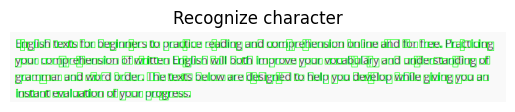

In [11]:
Charac(img)

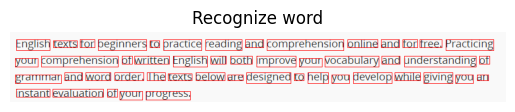

In [12]:
Word(img)

In [13]:
img = Image("OCR_eng.png")
transciption = OCR.image_to_string(
    image=img, 
    lang='eng',
    config=r'--psm 1 --oem 3'
)
Score(original_txt, transciption)

0.9875389408099688

In [14]:
Transcription(img, lang="frm", myconfig=r'--psm 1 --oem 3')

'English texts for beginners to practice reading and comprehension online and for free. Practicing\nYour comprehension of written English will both improve your vocabulary and understanding of\nBrammar and word order. The texts below are designed to help you develop while giving you an\n\ninstant evaluation of your progress.\n'

In [15]:
transcrip= np.empty((14, 4), dtype=np.dtype('U'))   # the output of the OCR
score= np.empty((14, 4))       # the score of this output

# For each possibility
for psm in range(0,14):
    for oem in range(0,4):
        # Score the result
        output = Transcription(img, lang='eng', myconfig=config(psm, oem))
        
        # Store the info
        transcrip[psm,oem] = output
        score[psm,oem] = Score(original_txt, output)
        #print(f"psm,eom : {(psm,oem)}\tScore: {round(score[psm,oem], 3)}\tTranscrip: {transcrip[psm,oem]}")
        

# Print best parameter
psm_max, oem_max = np.unravel_index(np.argmax(score), score.shape)
score_max = score[psm_max, oem_max]
print(f'Best parameter: psm {psm_max}\toem {oem_max}\nAssociate Score: {score_max}')

Best parameter: psm 4	oem 1
Associate Score: 0.9890795631825273


Text(0.5, 1.0, 'Best Config: psm 4 oem 1')

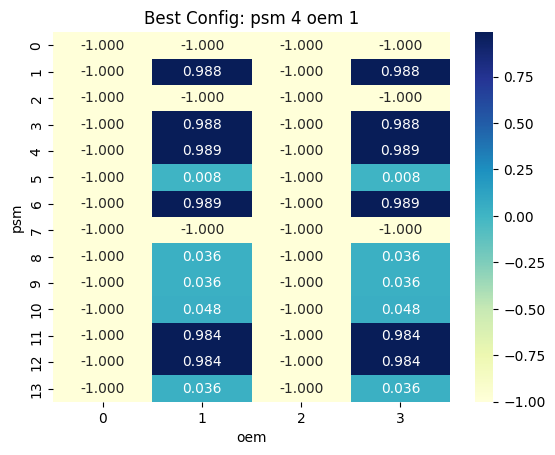

In [16]:
# Print the best config round 3 decimales
sns.heatmap(score, cmap="YlGnBu", annot=True, fmt=".3f")
plt.ylabel("psm")
plt.xlabel("oem")
plt.title(f"Best Config: psm {psm_max} oem {oem_max}")

# Test

In [15]:
img_name, psm, oem = "1391_1.jpg", 1, 1

img = Image(img_name)
myconfig = config(psm, oem)

for lang in ['eng', 'enm', 'frm', 'lat', 'oci']:
    transcrip = Transcription(img, lang=lang, myconfig=myconfig)
    key = f'{img_name} {lang}_{psm}.{oem}'
    
    Memorize(key, transcrip)
    print(lang, ": ", transcrip)

eng :  a <p ee
Aas or Pradou tart —.™/ q ane
Pee. nn Ss Se qkuts. 2 m2
v a5 atten
a * * a Ot tay fs reps ss
jim eae 5 TED 4

=| [
. “pole Duets — Crea 4
pits De ols Oo

Terabe lone

an yy
EB

_omentficens sf

ORS goo Te eee

: 52 foauan a
Saws * why gin hey * \ f « a Aas % %

~~

» .
4
ie


enm :  ESE a=
ws or Dwyey (avt— / Y Se
ERS... &: i: Qtrto. x- ZN
Wy Ws tors
% 28 X X a OO fawn, 1h rYpeE -
Meena oe) 44

— |
. le; Cretan e—Cpuas .
otitis 0b od 0. TT

Le es

av 7
&©

eter _

CO RDEL ATE EDI

- = ad
pe * wh A > s \ of « Lo Ag: * %

0

*- :
4
67


frm :  RAN A er ES
ds - BE CHa)t— N / GS 16
ME 51: Nt - TX
A - bb
+ X A OE Pd Ao A A 5
| ri 1 A

ré) |
- UN rh TN OS 7
RE D  D'a  TE

TE al

mr
SG

ſers 1

EEN TT

7E a
Ce « > s } :f « ui de AF: js.) Æ,

8

Hr ni
ä


lat :  E EX x]
es - oar Paseo Ut: d Tee
E... 8 3- State. 2- T
N X eise
x ES 3 is AS E Ma [p.51 "uA :
Mor mL Hh

ed i
: ocior Qut — Depaa: 4
vede som

adt e

due gt
Ae

centem zl

V urit neu V qus ess Rm

: T eor
Kc» * ves y * |

In [1]:
Charac(img)

NameError: name 'Charac' is not defined

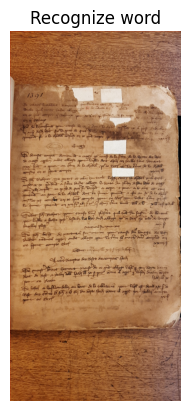

In [11]:
Word(img)